# Ciclo01: End to End

# 0.0 - IMPORTS 

In [1]:
import random

import pandas     as pd
import numpy      as np
import seaborn    as sns

from sklearn          import  model_selection    as ms
from sklearn          import preprocessing       as pp
from sklearn          import metrics             as m
from scikitplot       import metrics             as mt
from scipy            import stats               as ss

from keras import models as ml
from keras import layers as l

2022-03-29 22:23:34.607339: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-29 22:23:34.607368: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 0.1 - Helper functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k =  cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

## 0.2 - Loading data

In [3]:
df_raw = pd.read_csv('dataset/train_users_2.csv', low_memory=True)
df_sessions = pd.read_csv('dataset/sessions.csv', low_memory=True)

# 1.0 - DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()

## 1.1 - Data dimensions

In [5]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 213451
Number of columns: 16


In [6]:
print('Number of rows: {}'.format(df_sessions.shape[0]))
print('Number of columns: {}'.format(df_sessions.shape[1]))

Number of rows: 10567737
Number of columns: 6


## 1.2 - Data type

In [7]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

## 1.3 - NA check

In [8]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [9]:
# ======================== USER =======================#
# date_first_booking
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age
df1 = df1[(df1['age']>15) & (df1['age']<120)]
avg_age = df1['age'].mean().astype(int)
df1['age'] = df1['age'].fillna(avg_age)

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# ======================== SESSION =======================#
# user_id
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

# action
df_sessions = df_sessions[~df_sessions['action'].isna()]

# action_type
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

# action_detail
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

# secs_elapsed
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

## 1.4 - Change dtypes

In [10]:
# date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

#date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

# age
df1['age'] = df1['age'].astype(int)

## 1.5 - Check balanced data

In [11]:
df1['country_destination'].value_counts(normalize=True)

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

## 1.6 Descriptive analysis

In [12]:
# Users
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes = df1.select_dtypes(include=['datetime64[ns]'])

# Sessions
num_attributes_sessions = df_sessions.select_dtypes(include=['int64', 'float64'])
cat_attributes_sessions = df_sessions.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_sessions = df_sessions.select_dtypes(include=['datetime64[ns]'])

### 1.6.1 - Numerical - Users

In [13]:
# Central Tendecy - Mean and Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersions - Std, min, max, range, skew and kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                                       
# Concat
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,37.405591,34.0,13.939844,2.089718,6.516468
1,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


### 1.6.2 - Numerical - Sessions

In [14]:
# Central Tendecy - Mean and Median
ct1 = pd.DataFrame(num_attributes_sessions.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes_sessions.apply(np.median)).T

# Dispersions - Std, min, max, range, skew and kurtosis
d1 = pd.DataFrame(num_attributes_sessions.apply(np.std)).T
d2 = pd.DataFrame(num_attributes_sessions.apply(min)).T
d3 = pd.DataFrame(num_attributes_sessions.apply(max)).T
d4 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.kurtosis())).T
                                       
# Concat
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes_sessions', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes_sessions,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.6.3 - Categorical - Users

In [15]:
cat_attributes.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### 1.6.4 - Categorial - Sessions

In [16]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [17]:
# List of attributes for Cramer's V correlation
cat_attributes_list = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}
for i in range(len(cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref =  cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes_sessions[ref], cat_attributes_sessions[feat])
        
        # append a list
        corr_list.append(corr)
    # append list
    corr_dict[ref] = corr_list

<AxesSubplot:>

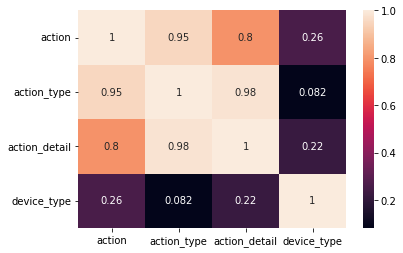

In [18]:
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

# 2.0 - FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

## 2.1 - Create new features

In [20]:
# days from first active up to first booking
df2['first_active'] = pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%Y-%m-%d'))
df2['days_from_first_active_until_booking'] = (df2['date_first_booking'] - df2['first_active']).apply(lambda x: x.days)

# days from first active upt to account created
df2['days_from_first_active_until_account_created'] = (df2['date_account_created'] - df2['first_active']).apply(lambda x: x.days)

# days from account created up to first booking
df2['days_from_account_created_until_first_booking'] = (df2['date_first_booking'] - df2['date_account_created']).apply(lambda x: x.days)

# ======================== Active ===========================#
# year first active
df2['year_first_active'] = df2['first_active'].dt.year

# month first active
df2['month_first_active'] = df2['first_active'].dt.month

# day first active
df2['day_first_active'] = df2['first_active'].dt.day

# day of week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

# week of year first active
df2['week_of_year_first_active'] = df2['first_active'].dt.isocalendar().week.astype(int)

# ======================== First Booking ===========================#
# year first booking
df2['year_date_first_booking'] = df2['date_first_booking'].dt.year

# month first booking
df2['month_date_first_booking'] = df2['date_first_booking'].dt.month

# day first booking
df2['day_date_first_booking'] = df2['date_first_booking'].dt.day

# day of week first booking
df2['day_of_year_date_first_booking'] = df2['date_first_booking'].dt.dayofweek

# week of year first booking
df2['week_of_year_date_first_booking'] = df2['date_first_booking'].dt.isocalendar().week.astype(int)

# ======================== Account Created ===========================#
# year account_created
df2['year_date_account_created'] = df2['date_account_created'].dt.year

# month account_created
df2['month_date_account_created'] = df2['date_account_created'].dt.month

# day account_created
df2['day_date_account_created'] = df2['date_account_created'].dt.day

# day of week account_created
df2['day_of_week_date_account_created'] = df2['date_account_created'].dt.dayofweek

# week of year account_created
df2['week_of_year_date_account_created'] = df2['date_account_created'].dt.isocalendar().week.astype(int)

# 3.0 - DATA FILTERING

In [21]:
df3 = df2.copy()

## 3.1 - Filtering rows

In [22]:
# age - greater than 15 and lower than 120 - There are few people over 120 years old
df3 = df3[(df3['age']>15) & df3['age']<120]

# secs_elapsed - there is no possible 0 secs elapsed on website
df_sessions = df_sessions[df_sessions['secs_elapsed']>0]

## 3.2 - Columns selection

# 4.0 - DATA PREPARATION

In [23]:
df4 = df3.copy()

In [24]:
# dummy variable
df4_dummy = pd.get_dummies(df4.drop(['id', 'country_destination'], axis=1))

# join id and country destination
df4 = pd.concat([df4[['id', 'country_destination']], df4_dummy], axis=1)

# 5.0 - FEATURE SELECTION

In [25]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active']
df5 = df4.drop(cols_drop, axis=1)

In [26]:
X = df5.drop(['country_destination'], axis=1)
y = df5['country_destination'].copy()

In [27]:
# Split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

# 6.0 MACHINE LEARNING MODEL - NEURAL NETWORK MLP

In [28]:
x_train = X_train.drop('id', axis=1)
x_test = X_test.drop('id', axis=1)

## 6.1 - Baseline model 

In [29]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination_weights = df1['country_destination'].value_counts(normalize=True).sort_index().to_list()

# modelo que chuta
yhat_random = random.choices(population=country_destination_list, k=k_num, weights=country_destination_weights)

### 6.1.1 - Baseline model performance

Accuracy: 0.3560828440965427
Balanced Accuracy: 0.08176125027853863
Kappa Score: -0.0026917012825389275
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        87
          CA       0.00      0.00      0.00       216
          DE       0.00      0.00      0.00       164
          ES       0.01      0.01      0.01       319
          FR       0.04      0.04      0.04       736
          GB       0.02      0.02      0.02       361
          IT       0.02      0.02      0.02       420
         NDF       0.44      0.44      0.44     10962
          NL       0.00      0.00      0.00       105
          PT       0.00      0.00      0.00        31
          US       0.39      0.39      0.39      9606
       other       0.06      0.06      0.06      1521

    accuracy                           0.36     24528
   macro avg       0.08      0.08      0.08     24528
weighted avg       0.36      0.36      0.36     24528



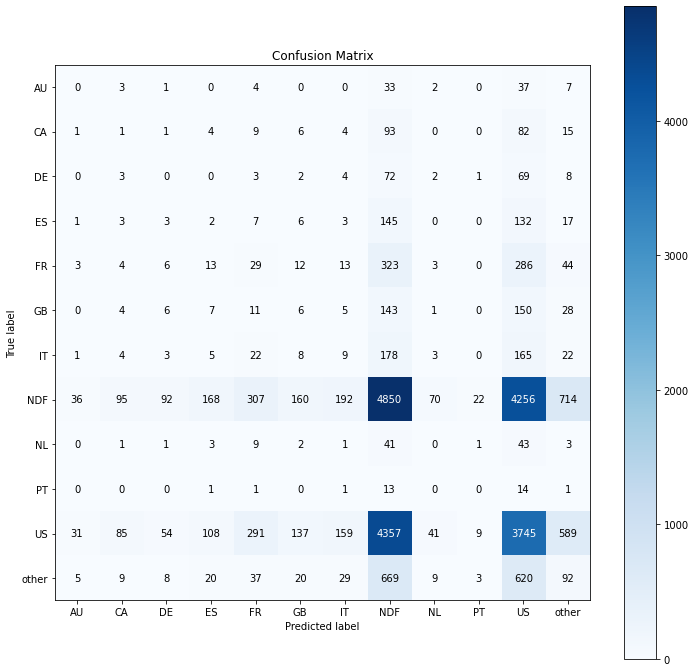

In [30]:
# Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification report
print(m.classification_report(y_test, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12, 12));

## 6.2 - Neural network - MLP

In [31]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()

In [32]:
# model definition
model = ml.Sequential()
model.add(l.Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(l.Dense(12, activation='softmax'))

# model_compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# trin model
model.fit(x_train, y_train_nn, epochs=100)

2022-03-29 22:26:37.706573: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-29 22:26:37.706610: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-29 22:26:37.706645: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fausto-Inspiron-7520): /proc/driver/nvidia/version does not exist


Epoch 1/100


2022-03-29 22:26:37.970946: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 108311232 exceeds 10% of free system memory.


3066/3066 [==============================] - 8s 2ms/step - loss: 7.5347 - accuracy: 0.7283
Epoch 2/100
3066/3066 [==============================] - 7s 2ms/step - loss: 2.8936 - accuracy: 0.7506
Epoch 3/100
3066/3066 [==============================] - 8s 3ms/step - loss: 1.5586 - accuracy: 0.7734
Epoch 4/100
3066/3066 [==============================] - 8s 2ms/step - loss: 0.9797 - accuracy: 0.8047
Epoch 5/100
3066/3066 [==============================] - 8s 2ms/step - loss: 0.7411 - accuracy: 0.8294
Epoch 6/100
3066/3066 [==============================] - 8s 2ms/step - loss: 0.6772 - accuracy: 0.8362
Epoch 7/100
3066/3066 [==============================] - 8s 2ms/step - loss: 0.6528 - accuracy: 0.8372
Epoch 8/100
3066/3066 [==============================] - 8s 2ms/step - loss: 0.6466 - accuracy: 0.8379
Epoch 9/100
3066/3066 [==============================] - 8s 2ms/step - loss: 0.6433 - accuracy: 0.8383
Epoch 10/100
3066/3066 [==============================] - 8s 2ms/step - loss: 0.6419 

Epoch 80/100
3066/3066 [==============================] - 8s 2ms/step - loss: 0.6338 - accuracy: 0.8391
Epoch 81/100
3066/3066 [==============================] - 8s 2ms/step - loss: 0.6362 - accuracy: 0.8387
Epoch 82/100
3066/3066 [==============================] - 8s 2ms/step - loss: 0.6331 - accuracy: 0.8391
Epoch 83/100
3066/3066 [==============================] - 8s 2ms/step - loss: 0.6337 - accuracy: 0.8391
Epoch 84/100
3066/3066 [==============================] - 8s 2ms/step - loss: 0.6334 - accuracy: 0.8391
Epoch 85/100
3066/3066 [==============================] - 8s 2ms/step - loss: 0.6334 - accuracy: 0.8391
Epoch 86/100
3066/3066 [==============================] - 7s 2ms/step - loss: 0.6339 - accuracy: 0.8390
Epoch 87/100
3066/3066 [==============================] - 8s 2ms/step - loss: 0.6345 - accuracy: 0.8390
Epoch 88/100
3066/3066 [==============================] - 8s 2ms/step - loss: 0.6334 - accuracy: 0.8391
Epoch 89/100
3066/3066 [==============================] - 8s 2ms

### 5.2.1 - NN Performance

In [33]:
# prediction
pred_nn = model.predict(x_test)

# invert_prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

Accuracy: 0.8384703196347032
Balanced Accuracy: 0.16664931639947256
Kappa Score: 0.7232441822459961


/home/fausto/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fausto/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fausto/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        87
          CA       0.00      0.00      0.00       216
          DE       0.00      0.00      0.00       164
          ES       0.00      0.00      0.00       319
          FR       0.00      0.00      0.00       736
          GB       0.00      0.00      0.00       361
          IT       0.00      0.00      0.00       420
         NDF       1.00      1.00      1.00     10962
          NL       0.00      0.00      0.00       105
          PT       0.00      0.00      0.00        31
          US       0.71      1.00      0.83      9606
       other       0.00      0.00      0.00      1521

    accuracy                           0.84     24528
   macro avg       0.14      0.17      0.15     24528
weighted avg       0.72      0.84      0.77     24528



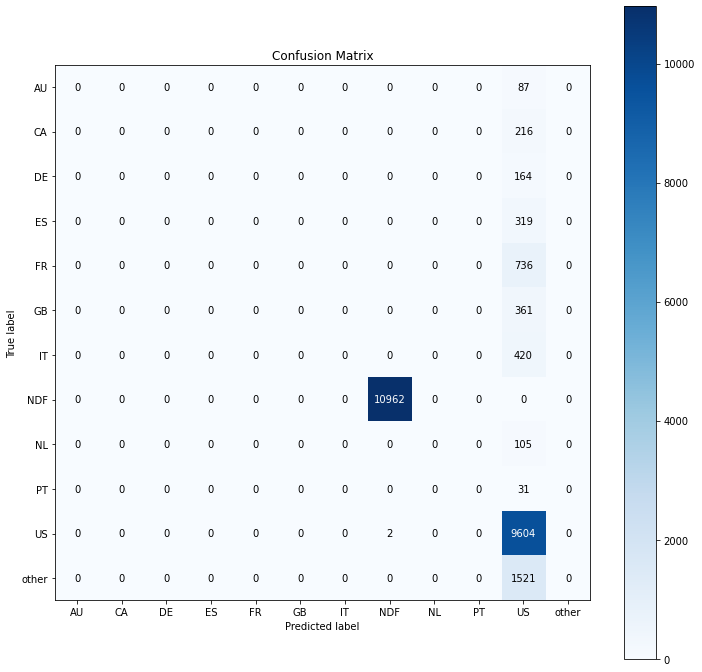

In [34]:
# Accuracy
acc_nn = m.accuracy_score(y_test, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_nn))

# Classification report
print(m.classification_report(y_test_nn, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12, 12));

### 5.2.2- NN Performance - Cross-Validation

In [ ]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split(x_train, y_train):
    print('Fold number: {}/{}'.format(i, num_folds))
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot_encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1,1)).toarray()
    
    # model definition
    model = ml.Sequential()
    model.add(l.Dense(256, input_dim=x_train.shape[1],activation='relu'))
    model.add(l.Dense(11, activation='softmax'))
    
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # training model
    model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)
    
    # prediction
    pred_nn = model.predict(x_val_fold)
    yhat_nn = ohe.inverse_transform(pred_nn)
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape(1, -1)[0]
    
    # metrics
    ## Balanced Accuracy
    balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_list.append(balanced_acc_nn)
    
    ## Kappa Accuracy
    kappa_acc_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
    kappa_acc_list.append(kappa_acc_nn)
    
    i += 1

In [ ]:
print(' Avg Balanced accuracy: {} +/- {}'.format(np.mean(balanced_acc_list), np.std(balanced_acc_list)))
print(' Kappa Balanced accuracy: {} +/- {}'.format(np.mean(kappa_acc_list), np.std(kappa_acc_list)))